In [35]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


In [ ]:
genres = os.listdir("../data/genres_original")
genres.sort()

In [ ]:
genre_file_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join("../data/genres_original", genre)
    
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    count = len(files)  
    genre_file_counts[genre] = count
    total_files += count
    
    print(f"{genre:15} : {count:3} files")


In [ ]:
plt.figure(figsize=(14, 6))  # increase width
plt.bar(
    genre_file_counts.keys(),      # X values (genre names)
    genre_file_counts.values(),
)
plt.savefig("../results/plots/distribution.png")

In [ ]:
audio_properties = []
for genre in genres:
    c = 0
    genre_path = os.path.join(f"../data/genres_original/{genre}")
    files=  []
    for f in os.listdir(genre_path):
        c+=1
        if c >= 6:
            break 
        files.append(f) 

    for file  in files:
        file_path = os.path.join(genre_path, file)
        wave_form , sample_rate = librosa.load(file_path)
        n_samples = len(wave_form)
        duration = librosa.get_duration(y=wave_form, sr=sample_rate)
        audio_properties.append({
                'genre': genre,
                'filename': file,
                'duration_sec': duration,
                'sample_rate': sample_rate,
                'n_samples': n_samples,
                'min_amplitude': np.min(wave_form),      # Quietest point
                'max_amplitude': np.max(wave_form),      # Loudest point
                'mean_amplitude': np.mean(np.abs(wave_form)),  # Average loudness
                'std_amplitude': np.std(wave_form)       # Variation in loudness
        })

df = pd.DataFrame(audio_properties)



In [ ]:
genre_amplitudes = df.groupby('genre').agg({
    'mean_amplitude': 'mean',
    'max_amplitude': 'mean',
    'min_amplitude': 'mean'
}).reset_index()
genre_amplitudes

In [ ]:
plt.figure(figsize=(14, 6))

sns.boxplot(data=df, x='genre', y='mean_amplitude', palette='Set2')

plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Mean Amplitude', fontsize=12, fontweight='bold')
plt.title('Amplitude Comparison Across Genres (Box Plot)', fontsize=14, fontweight='bold')
plt.savefig("../results/plots/amplitude_boxplot.png", dpi=300)


In [ ]:
for genre in genres:
    c = 0
    genre_path = os.path.join(f"../data/genres_original/{genre}")
    files=  []
    for f in os.listdir(genre_path):
        c+=1
        if c >= 2:
            break 
        files.append(f) 

    for file  in files:
        file_path = os.path.join(genre_path, file)
        wave_form , sample_rate = librosa.load(file_path)
        librosa.display.waveshow(wave_form,sr=sample_rate)
        plt.title(f"{genre} waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"../results/plots/{genre}_waveform.png", dpi=300)


In [ ]:
def extract_features(file_path):
        y, sr = librosa.load(file_path, duration=30)
        features = {}
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) #Mel-frequency Cepstral Coefficients
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i}_std'] = np.std(mfccs[i])

        # Spectral Centroids
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['rolloff_mean'] = np.mean(rolloff)
        features['rolloff_std'] = np.std(rolloff)

        # Zero Crossing Rate 
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)

        # Chroma (harmony)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i}_mean'] = np.mean(chroma[i])
    
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        # RMS Energy (loudness)
        rms = librosa.feature.rms(y=y)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)

        return features

In [ ]:

all_features = []
file_count = 0

for genre in genres:
    print(f"\nProcessing genre: {genre}")
    genre_path = os.path.join("../data/genres_original", genre)
    
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    
    for i, file in enumerate(files):
        file_path = os.path.join(genre_path, file)
        
        try:
            features = extract_features(file_path)
                
            features['genre'] = genre
            features['filename'] = file
            
            all_features.append(features)
            
            file_count += 1
            
            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{len(files)} files...")
                
        except Exception as e:
            print(f"  Error with {file}: {e}")


print(f"Feature extraction complete!")
print(f"Processed {file_count} files")

df_features = pd.DataFrame(all_features)

df_features.to_csv('../data/features.csv', index=False)


In [ ]:
df = df_features
df.columns.to_list()

In [ ]:
missing = df_features.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    print("Missing values found:")
else:
    print("No missing values")

feature_cols = df_features.select_dtypes(include=[np.number]).columns
inf_count = 0

for col in feature_cols:
    inf = np.isinf(df_features[col]).sum()
    if inf > 0:
        print(f"{col}: {inf} infinite values")
        inf_count += inf

if inf_count == 0:
    print("No infinite values")
else:
    print(f"Total infinite values: {inf_count}")

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [ ]:
y = df["genre"]
x=df.drop(['genre', 'filename'], axis=1)


In [85]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

x_train ,x_test ,y_train , y_test = train_test_split(x,y)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [86]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    criterion='entropy',
    random_state=42,
    max_features=10,
)

In [87]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

a = accuracy_score(y_pred , y_test)
print(a)

0.644


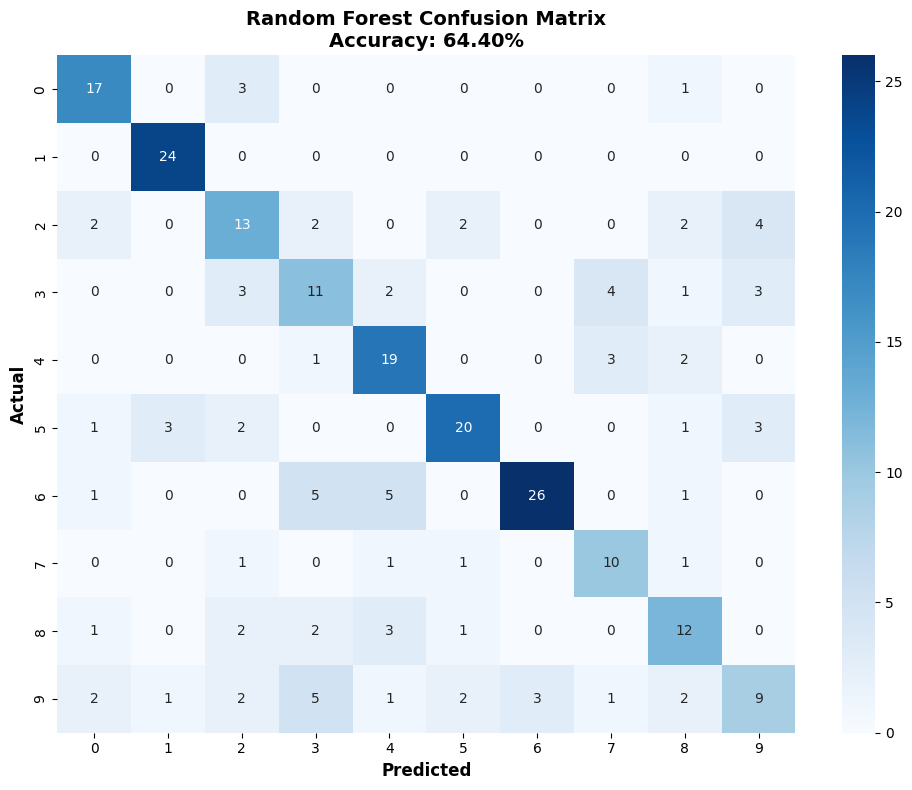

In [88]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.title(f'Random Forest Confusion Matrix\nAccuracy: {a:.2%}', 
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../results/plots/rf_confusion_matrix.png', dpi=300)
plt.show()


In [89]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    eval_metric='mlogloss'
)


In [90]:
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
a1= accuracy_score(y_test , y_pred)
print(a1)

0.548


<Axes: >

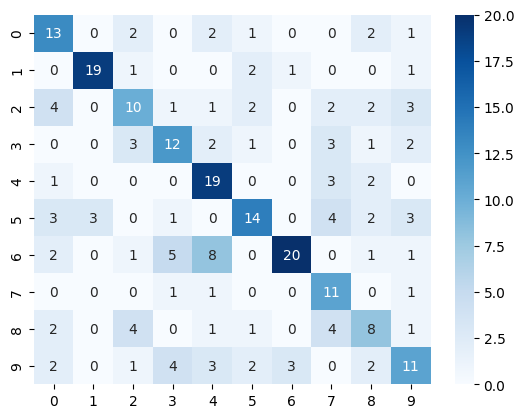

In [91]:
cm = confusion_matrix(y_test , y_pred)
sns.heatmap(cm,annot=True , cmap="Blues")